# 13.2 終点誤差分散最小モデル (minimum-variance model)
**終点誤差分散最小モデル** (minimum-variance model; Harris & Wolpert, 1998)を実装する．

## 13.2.1 終点誤差分散最小モデルの実装
以下では田中先生の<https://motorcontrol.jp/mc13/MC2019_2_OptimalControlStochastic.pdf>のコードを参考に作成した．

In [1]:
using LinearAlgebra, Random, ToeplitzMatrices, PyPlot

In [2]:
eye(T::Type, n) = Diagonal{T}(I, n)
eye(n) = eye(Float64, n)
vec(X) = vcat(X...)

vec (generic function with 1 method)

13.1で用いたものと同じ．

In [3]:
# Equality Constrained Quadratic Programming
function solveEqualityConstrainedQuadProg(P, q, A, b)
    """
    minimize   : 1/2 * x'*P*x + q'*x
    subject to : A*x = b
    """
    K = [P A'; A zeros(size(A)[1], size(A)[1])] # KKT matrix
    sol = K \ [-q; b]
    return sol[1:size(A)[2]]
end

solveEqualityConstrainedQuadProg (generic function with 1 method)

In [4]:
t1 = 224*1e-3 # time const of eye dynamics (s)
t2 = 13*1e-3  # another time const of eye dynamics (s)
tm = 10*1e-3
dt = 1e-3     # simulation time step (s)
tf = 50*1e-3  # movement duration (s)
tp = 20*1e-3  # post-movement duration (s)
K = round(Int, tf/dt)
L = round(Int, tp/dt)
trange = (1:K+L) * dt * 1e3 # ms

x0 = zeros(3)       # initial state (pos=0, vel=0, acc=0)
xf = [10; zeros(2)] # final state (pos=10, vel=0, acc=0)
α1 = -1/(t1*t2*tm)
α2 = -1/(t1*t2)-1/(t1*tm)-1/(t2*tm)
α3 = -1/t1-1/t2-1/tm
Ac = [0 1 0; 0 0 1; α1 α2 α3];
Bc = [zeros(2); 1]
A = exp(Ac*dt);
B = Ac^-1 * (eye(3) - exp(Ac*dt))*Bc;

In [5]:
# calculation of Q
diagQ = zeros(K+L);
for ell=0:K+L-1
    if ell < K
        diagQ[ell+1] = sum([(A^(k-ell-1) * B * B' * A'^(k-ell-1))[1,1] for k=K:K+L-1])
    else
        diagQ[ell+1] = diagQ[ell] + (A^(K+L-ell-2) * B * B' * A'^(K+L-ell-2))[1,1]
    end
end
diagQ *= 10^13 # for numerical stability
Q = Diagonal(diagQ); 

制約条件における行列Cとベクトルdの計算．

In [6]:
# calculation of C
C = []
for p=1:L+1
    Ctmp = []
    for q=1:K+L
        if q == 1
            Ctmp = A^(K-1-(q-1)+(p-1))*B
        else
            if K-1-(q-1)+(p-1) >= 0
                Ctmp = [Ctmp A^(K-1-(q-1)+(p-1))*B]; # if K-1-(q-1)+(p-1) == 0; A^(K-1-(q-1)+(p-1))*B equal to B
            else
                Ctmp = [Ctmp zeros(3)];
            end
        end
    end
    if p == 1
        C = Ctmp
    else
        C = [C; Ctmp]
    end
end

In [7]:
# calculation of d
d = vec([xf - A^(K+ell) * x0 for ell=0:L]);

制御信号を二次計画法で計算．

In [8]:
# solution by quadratic programming
u = solveEqualityConstrainedQuadProg(Q, zeros(K+L), C, d);

シミュレーションの実行．

In [9]:
# forward solution
x = zeros(3, K+L);
x[:,1] = x0;
for k=1:K+L-1
    x[:,k+1] = A*x[:, k] + B*u[k]
end

結果の描画．

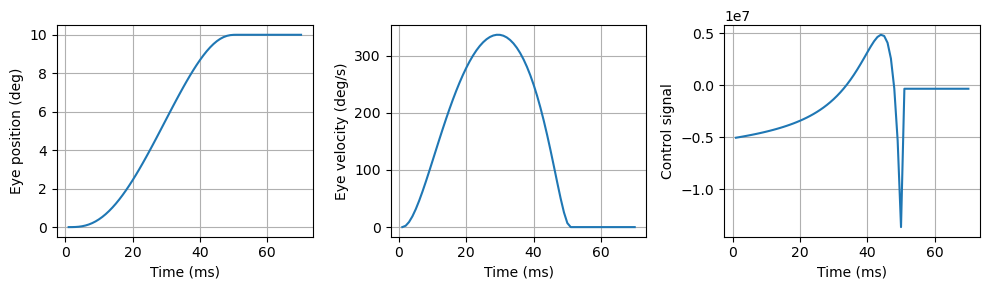

In [10]:
figure(figsize=(10, 3))
subplot(1,3,1)
plot(trange, x[1, :])
ylabel("Eye position (deg)"); xlabel("Time (ms)"); grid()
subplot(1,3,2)
plot(trange, x[2, :])
ylabel("Eye velocity (deg/s)"); xlabel("Time (ms)"); grid()
subplot(1,3,3)
plot(trange, u)
ylabel("Control signal"); xlabel("Time (ms)"); grid()
tight_layout()